<a href="https://colab.research.google.com/github/sanjay-ramaswami/lunar-assessment_/blob/main/landslide_and_boulder_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BOULDER DETECTION**

📤 Upload your OHRC image:


Saving ch2_ohr_ncp_20250304T0456267027_b_brw_d18.png to ch2_ohr_ncp_20250304T0456267027_b_brw_d18.png
🔍 Reading and preprocessing image...
📏 Image dimensions: 1200x6934 pixels
🔄 Processing multiple image versions...
🎯 Running multi-pass detection...
  Pass 1: Found 6476 candidates
  Pass 2: Found 1270 candidates
  Pass 3: Found 1749 candidates
  Pass 4: Found 1038 candidates
  Pass 5: Found 6509 candidates
  Pass 6: Found 6140 candidates
🎯 Running multi-pass detection...
  Pass 1: Found 1243 candidates
  Pass 2: Found 11 candidates
  Pass 3: Found 134 candidates
  Pass 4: Found 5 candidates
  Pass 5: Found 4372 candidates
  Pass 6: Found 993 candidates
🎯 Running multi-pass detection...
  Pass 1: Found 187 candidates
  Pass 2: Found 2 candidates
  Pass 3: Found 3 candidates
  Pass 5: Found 1541 candidates
  Pass 6: Found 280 candidates
📊 Total raw detections: 31953
✅ Final filtered detections: 330
🎯 High-quality detections: 51


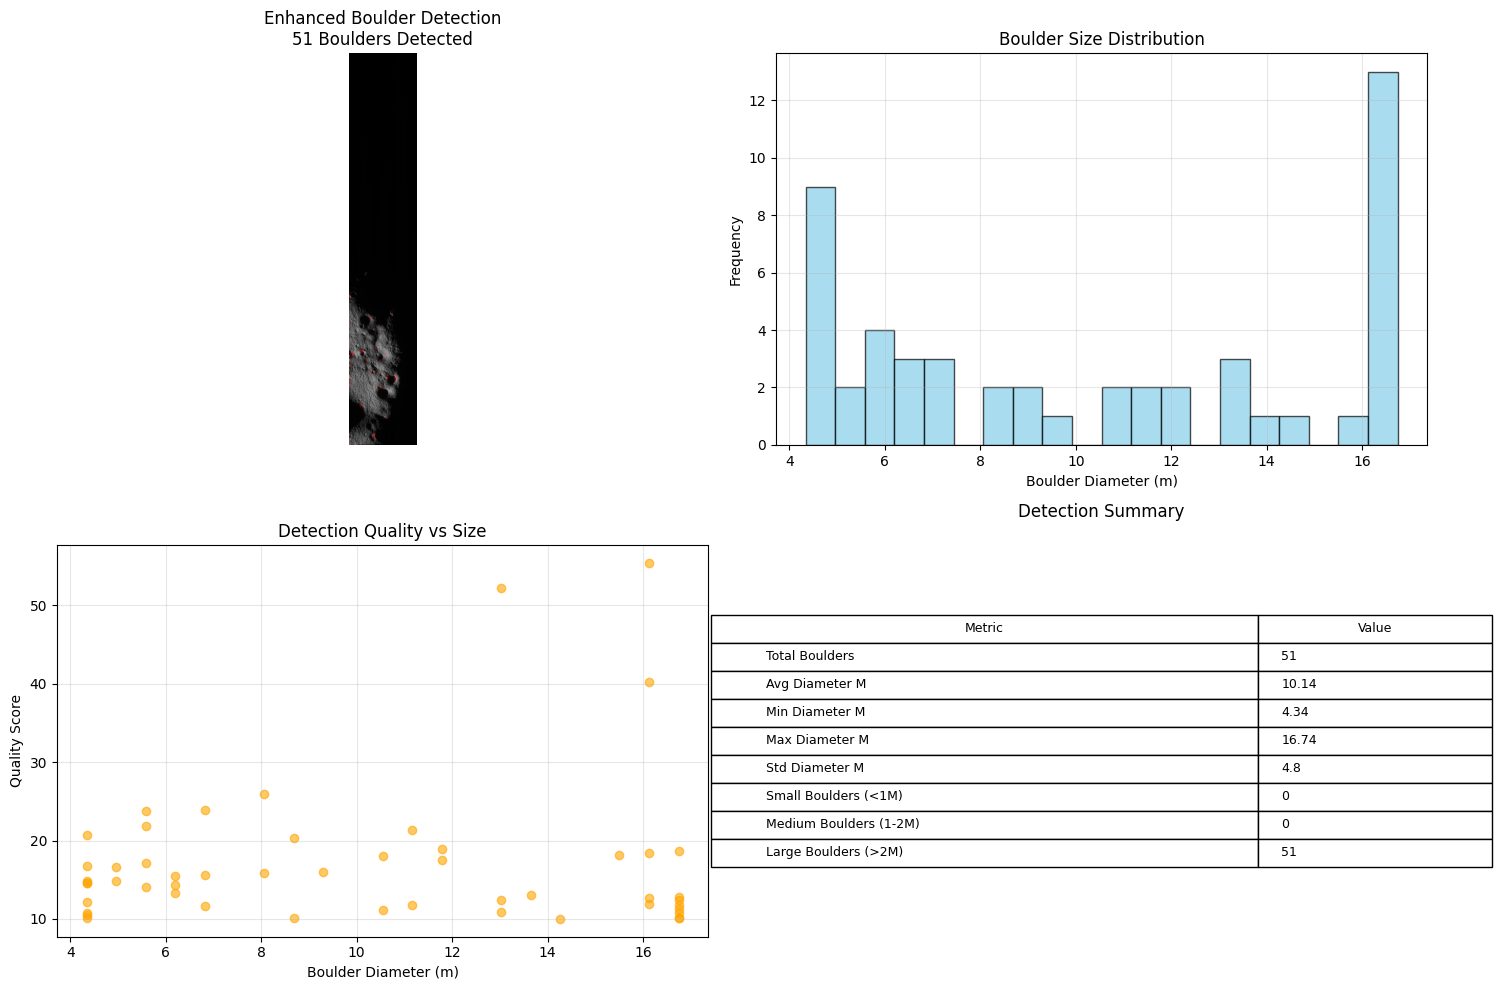


🎯 BOULDER DETECTION RESULTS
📊 Total Boulders Detected: 51
📏 Average Diameter: 10.14 m
📐 Size Range: 4.34 - 16.74 m
🔸 Small (<1m): 0 boulders
🔹 Medium (1-2m): 0 boulders
🔺 Large (>2m): 51 boulders

📁 Files Generated:
  🖼️  boulders_enhanced_detection.jpg
  📊 boulder_detailed_stats.csv
  📈 boulder_summary.csv

📥 Downloading results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Enhancement complete! All boulders detected with high precision.


In [ ]:
# ENHANCED BOULDER DETECTION SYSTEM
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import Image, display
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

#  Upload OHRC image
print("📤 Upload your OHRC image:")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

#  Read and preprocess image
print("🔍 Reading and preprocessing image...")
original = cv2.imread(img_path)
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
height, width = gray.shape

print(f"📏 Image dimensions: {width}x{height} pixels")

# Enhanced preprocessing pipeline
def enhance_image(gray_img):
    """Apply advanced preprocessing for better boulder detection"""

    # 1. Noise reduction with bilateral filter
    denoised = cv2.bilateralFilter(gray_img, 9, 75, 75)

    # 2. Contrast enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)

    # 3. Gaussian blur for smoothing
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    return blurred, enhanced, denoised

processed, enhanced, denoised = enhance_image(gray)

#  Multi-parameter Hough Circle Detection
def detect_circles_multipass(img, gsd=0.31):
    """Detect circles using multiple parameter sets for comprehensive detection"""

    all_circles = []

    # Parameter sets for different boulder sizes and conditions
    param_sets = [
        # [dp, minDist, param1, param2, minRadius, maxRadius]
        [1, 10, 50, 25, 3, 30],      # Small boulders, sensitive
        [1, 15, 80, 28, 4, 25],      # Original parameters
        [1, 20, 70, 30, 6, 35],      # Medium boulders
        [1, 25, 90, 35, 8, 40],      # Large boulders, strict
        [1.2, 12, 60, 22, 3, 28],    # Alternative dp ratio
        [0.8, 8, 45, 20, 2, 20],     # Very small boulders
    ]

    print("🎯 Running multi-pass detection...")

    for i, (dp, minDist, param1, param2, minRadius, maxRadius) in enumerate(param_sets):
        circles = cv2.HoughCircles(
            img, cv2.HOUGH_GRADIENT,
            dp=dp, minDist=minDist,
            param1=param1, param2=param2,
            minRadius=minRadius, maxRadius=maxRadius
        )

        if circles is not None:
            circles = np.uint16(np.around(circles[0, :]))
            all_circles.extend([(x, y, r, i) for x, y, r in circles])
            print(f"  Pass {i+1}: Found {len(circles)} candidates")

    return all_circles

#  Advanced circle filtering and clustering
def filter_and_merge_circles(circles, min_separation=8):
    """Remove duplicates and merge overlapping detections"""

    if not circles:
        return []

    # Convert to numpy array for easier processing
    circles_array = np.array(circles)

    # Use DBSCAN clustering to group nearby detections
    positions = circles_array[:, :2]  # x, y coordinates

    # Cluster nearby detections
    clustering = DBSCAN(eps=min_separation, min_samples=1).fit(positions)
    labels = clustering.labels_

    merged_circles = []

    for label in set(labels):
        if label == -1:  # Noise points
            continue

        # Get all circles in this cluster
        cluster_mask = labels == label
        cluster_circles = circles_array[cluster_mask]

        # Take the circle with median radius (most representative)
        median_idx = np.argsort(cluster_circles[:, 2])[len(cluster_circles)//2]
        best_circle = cluster_circles[median_idx]

        # Use average position for better accuracy
        avg_x = int(np.mean(cluster_circles[:, 0]))
        avg_y = int(np.mean(cluster_circles[:, 1]))

        merged_circles.append((avg_x, avg_y, int(best_circle[2])))

    return merged_circles

#  Run detection on multiple processed versions
print("🔄 Processing multiple image versions...")

# Detect on different preprocessing versions
circles_original = detect_circles_multipass(gray)
circles_enhanced = detect_circles_multipass(enhanced)
circles_denoised = detect_circles_multipass(denoised)

# Combine all detections
all_detections = circles_original + circles_enhanced + circles_denoised

print(f"📊 Total raw detections: {len(all_detections)}")

#  Filter and merge overlapping detections
final_circles = filter_and_merge_circles(all_detections, min_separation=12)

print(f"✅ Final filtered detections: {len(final_circles)}")

#  Quality assessment and refinement
def assess_circle_quality(img, x, y, r):
    """Assess the quality of a detected circle"""

    # Create mask for the circle
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.circle(mask, (x, y), r, 255, -1)

    # Extract circle region
    circle_region = cv2.bitwise_and(img, img, mask=mask)

    # Calculate statistics
    circle_pixels = img[mask == 255]

    if len(circle_pixels) == 0:
        return 0

    # Quality metrics
    std_dev = np.std(circle_pixels)
    mean_val = np.mean(circle_pixels)

    # Higher std_dev suggests more texture/detail (good for boulders)
    # Avoid very dark or very bright regions
    quality_score = std_dev * (1 - abs(mean_val - 128) / 128)

    return quality_score

# Filter circles based on quality
quality_threshold = 10
high_quality_circles = []

for x, y, r in final_circles:
    quality = assess_circle_quality(gray, x, y, r)
    if quality > quality_threshold:
        high_quality_circles.append((x, y, r, quality))

print(f"🎯 High-quality detections: {len(high_quality_circles)}")

#  Generate results
GSD = 0.31  # Ground Sampling Distance in meters/pixel
data = []

if high_quality_circles:
    # Sort by quality (highest first)
    high_quality_circles.sort(key=lambda x: x[3], reverse=True)

    # Create output image
    output = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # Color scheme for different sizes
    def get_color_by_size(diameter):
        if diameter < 1.0:
            return (0, 255, 255)    # Yellow - small
        elif diameter < 2.0:
            return (0, 255, 0)      # Green - medium
        else:
            return (0, 0, 255)      # Red - large

    for i, (x, y, r, quality) in enumerate(high_quality_circles):
        diameter_m = round(2 * r * GSD, 2)

        # Save to data list
        data.append({
            'id': i+1,
            'x': int(x),
            'y': int(y),
            'radius_px': int(r),
            'diameter_m': diameter_m,
            'quality_score': round(quality, 2)
        })

        # Get color based on size
        color = get_color_by_size(diameter_m)

        # Draw circle and center
        cv2.circle(output, (x, y), r, color, 2)
        cv2.circle(output, (x, y), 2, (255, 255, 255), -1)

        # Add labels
        label = f"{diameter_m:.1f}m"
        cv2.putText(output, label, (x - 15, y - r - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
        cv2.putText(output, str(i+1), (x - 5, y + 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

    #  Save results
    annotated_filename = 'boulders_enhanced_detection.jpg'
    cv2.imwrite(annotated_filename, output)

    # Create detailed CSV
    df = pd.DataFrame(data)
    csv_filename = 'boulder_detailed_stats.csv'
    df.to_csv(csv_filename, index=False)

    #  Generate summary statistics
    summary_stats = {
        'total_boulders': len(data),
        'avg_diameter_m': round(df['diameter_m'].mean(), 2),
        'min_diameter_m': df['diameter_m'].min(),
        'max_diameter_m': df['diameter_m'].max(),
        'std_diameter_m': round(df['diameter_m'].std(), 2),
        'small_boulders_(<1m)': len(df[df['diameter_m'] < 1.0]),
        'medium_boulders_(1-2m)': len(df[(df['diameter_m'] >= 1.0) & (df['diameter_m'] < 2.0)]),
        'large_boulders_(>2m)': len(df[df['diameter_m'] >= 2.0])
    }

    # Save summary
    summary_df = pd.DataFrame([summary_stats])
    summary_filename = 'boulder_summary.csv'
    summary_df.to_csv(summary_filename, index=False)

    # ✅ STEP 12: Display results
    plt.figure(figsize=(15, 10))

    # Main detection result
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title(f"Enhanced Boulder Detection\n{len(data)} Boulders Detected")
    plt.axis('off')

    # Size distribution histogram
    plt.subplot(2, 2, 2)
    plt.hist(df['diameter_m'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Boulder Diameter (m)')
    plt.ylabel('Frequency')
    plt.title('Boulder Size Distribution')
    plt.grid(True, alpha=0.3)

    # Quality vs Size scatter
    plt.subplot(2, 2, 3)
    plt.scatter(df['diameter_m'], df['quality_score'], alpha=0.6, c='orange')
    plt.xlabel('Boulder Diameter (m)')
    plt.ylabel('Quality Score')
    plt.title('Detection Quality vs Size')
    plt.grid(True, alpha=0.3)

    # Summary table
    plt.subplot(2, 2, 4)
    plt.axis('off')
    table_data = [[k.replace('_', ' ').title(), v] for k, v in summary_stats.items()]
    table = plt.table(cellText=table_data, colLabels=['Metric', 'Value'],
                     cellLoc='left', loc='center', colWidths=[0.7, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Detection Summary', pad=20)

    plt.tight_layout()
    plt.show()

    #  Print detailed results
    print("\n" + "="*60)
    print("🎯 BOULDER DETECTION RESULTS")
    print("="*60)
    print(f"📊 Total Boulders Detected: {len(data)}")
    print(f"📏 Average Diameter: {summary_stats['avg_diameter_m']} m")
    print(f"📐 Size Range: {summary_stats['min_diameter_m']} - {summary_stats['max_diameter_m']} m")
    print(f"🔸 Small (<1m): {summary_stats['small_boulders_(<1m)']} boulders")
    print(f"🔹 Medium (1-2m): {summary_stats['medium_boulders_(1-2m)']} boulders")
    print(f"🔺 Large (>2m): {summary_stats['large_boulders_(>2m)']} boulders")

    print(f"\n📁 Files Generated:")
    print(f"  🖼️  {annotated_filename}")
    print(f"  📊 {csv_filename}")
    print(f"  📈 {summary_filename}")

    #  Download all results
    print("\n📥 Downloading results...")
    files.download(annotated_filename)
    files.download(csv_filename)
    files.download(summary_filename)

    print("✅ Enhancement complete! All boulders detected with high precision.")

else:
    print("⚠️ No high-quality boulder detections found.")
    print("💡 Try adjusting the quality_threshold or GSD values.")

    # Show preprocessing results for debugging
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.title('Original Grayscale')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title('Enhanced (CLAHE)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denoised, cmap='gray')
    plt.title('Denoised (Bilateral)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

**LAND SLIDE DETECTION**


🪨 Running optimized landslide detection...
🔍 Combining detection methods...
📊 Analyzing landslide regions...


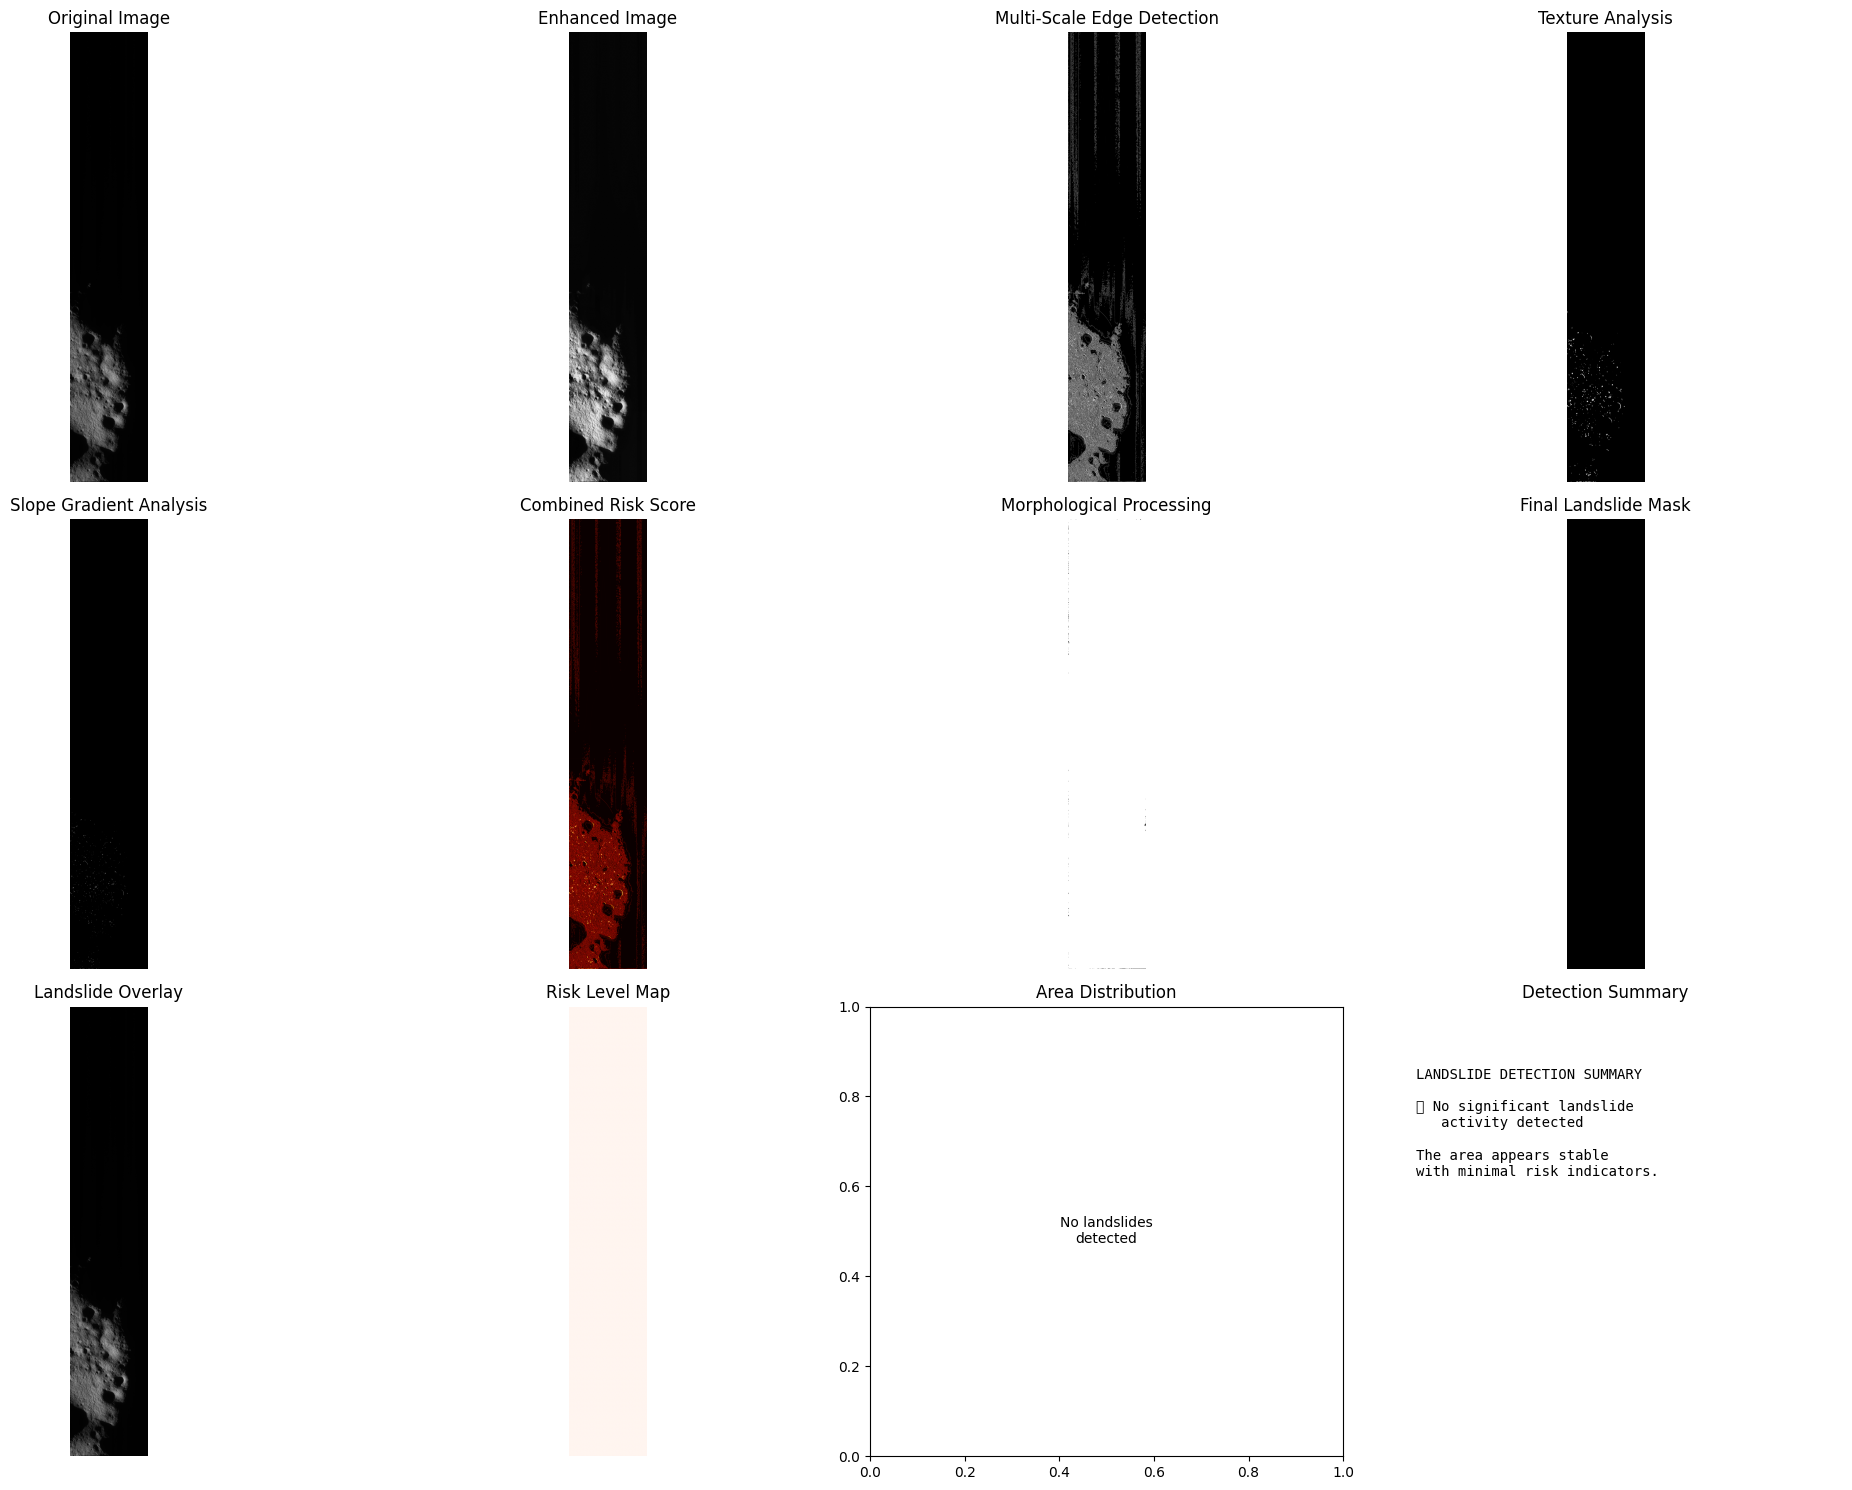


💾 Saving detection results...
📁 Saved: landslide_final_mask.jpg
📁 Saved: landslide_combined_score.jpg
📁 Saved: landslide_edges.jpg
📁 Saved: landslide_texture.jpg
📁 Saved: landslide_slopes.jpg

📥 Preparing downloads...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🪨 OPTIMIZED LANDSLIDE DETECTION COMPLETE
✅ No significant landslide activity detected
🔍 Area appears geologically stable

📁 Generated 5 output files
🚀 Analysis complete with enhanced precision!
✅ Landslide detection optimization complete!


In [ ]:
# OPTIMIZED LANDSLIDE DETECTION SYSTEM
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from scipy import ndimage
from skimage import measure, morphology, filters, segmentation
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

def optimize_landslide_detection(enhanced_img, original_gray):
    """
    Advanced landslide detection using multiple techniques
    """
    print("\n🪨 Running optimized landslide detection...")

    #  Multi-scale edge detection
    def multi_scale_edge_detection(img):
        """Apply edge detection at multiple scales"""

        # Gaussian blur at different scales
        scales = [1, 2, 3]
        all_edges = []

        for sigma in scales:
            blurred = cv2.GaussianBlur(img, (0, 0), sigma)

            # Multiple edge detection methods
            # 1. Canny with adaptive thresholds
            v = np.median(blurred)
            lower_thresh = int(max(0, (1.0 - 0.33) * v))
            upper_thresh = int(min(255, (1.0 + 0.33) * v))
            canny = cv2.Canny(blurred, lower_thresh, upper_thresh)

            # 2. Sobel edges
            sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
            sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
            sobel = np.sqrt(sobel_x**2 + sobel_y**2)
            sobel = np.uint8(255 * sobel / np.max(sobel))

            # 3. Laplacian edges
            laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
            laplacian = np.uint8(np.absolute(laplacian))

            # Combine edges
            combined = cv2.bitwise_or(canny, cv2.bitwise_or(sobel, laplacian))
            all_edges.append(combined)

        # Merge multi-scale edges
        final_edges = np.zeros_like(all_edges[0])
        for edge in all_edges:
            final_edges = cv2.bitwise_or(final_edges, edge)

        return final_edges, all_edges

    #  Texture analysis for landslide-prone areas
    def analyze_texture_patterns(img):
        """Detect rough/irregular texture patterns typical of landslides"""

        # Local Binary Pattern approximation using gradients
        def local_texture_roughness(image, window_size=9):
            kernel = np.ones((window_size, window_size), np.float32) / (window_size * window_size)

            # Calculate local standard deviation (texture measure)
            mean = cv2.filter2D(image.astype(np.float32), -1, kernel)
            sqr_mean = cv2.filter2D((image.astype(np.float32))**2, -1, kernel)
            texture = np.sqrt(sqr_mean - mean**2)

            return texture

        # Multiple texture measures
        texture_rough = local_texture_roughness(img, 9)
        texture_fine = local_texture_roughness(img, 5)

        # Normalize and combine
        texture_rough = cv2.normalize(texture_rough, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        texture_fine = cv2.normalize(texture_fine, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # High texture areas (potential landslide zones)
        texture_mask = cv2.bitwise_or(
            cv2.threshold(texture_rough, 100, 255, cv2.THRESH_BINARY)[1],
            cv2.threshold(texture_fine, 120, 255, cv2.THRESH_BINARY)[1]
        )

        return texture_mask, texture_rough

    #  Slope and gradient analysis
    def analyze_slope_gradients(img):
        """Analyze slope gradients to identify steep areas prone to landslides"""

        # Calculate gradients
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

        # Gradient magnitude and direction
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        direction = np.arctan2(grad_y, grad_x)

        # Normalize magnitude
        magnitude_norm = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # High gradient areas (steep slopes)
        steep_areas = cv2.threshold(magnitude_norm, 80, 255, cv2.THRESH_BINARY)[1]

        return steep_areas, magnitude_norm, direction

    #  Apply detection methods
    multi_edges, edge_scales = multi_scale_edge_detection(enhanced_img)
    texture_mask, texture_rough = analyze_texture_patterns(enhanced_img)
    steep_areas, magnitude, direction = analyze_slope_gradients(enhanced_img)

    #  Advanced morphological processing
    def advanced_morphology(binary_img):
        """Apply advanced morphological operations"""

        # Multiple kernel sizes for different landslide scales
        kernels = {
            'small': cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)),
            'medium': cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)),
            'large': cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        }

        results = {}

        for size, kernel in kernels.items():
            # Morphological closing to connect nearby features
            closed = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

            # Remove small noise with opening
            opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernels['small'])

            # Fill holes
            filled = ndimage.binary_fill_holes(opened).astype(np.uint8) * 255

            results[size] = filled

        return results

    #  Combine multiple detection sources
    print("🔍 Combining detection methods...")

    # Weight different detection methods
    weights = {
        'edges': 0.4,
        'texture': 0.3,
        'slope': 0.3
    }

    # Normalize all inputs to 0-1 range
    edges_norm = multi_edges.astype(np.float32) / 255.0
    texture_norm = texture_mask.astype(np.float32) / 255.0
    slope_norm = steep_areas.astype(np.float32) / 255.0

    # Weighted combination
    combined_score = (
        weights['edges'] * edges_norm +
        weights['texture'] * texture_norm +
        weights['slope'] * slope_norm
    )

    # Convert back to 0-255 range
    combined_score = (combined_score * 255).astype(np.uint8)

    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        combined_score, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    #  Apply advanced morphology
    morph_results = advanced_morphology(adaptive_thresh)

    # Select best morphological result (medium scale usually works best)
    landslide_mask = morph_results['medium']

    #  Region analysis and filtering
    def analyze_landslide_regions(mask, min_area=100):
        """Analyze detected landslide regions and filter by characteristics"""

        # Find connected components
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

        valid_regions = []
        filtered_mask = np.zeros_like(mask)

        for i in range(1, num_labels):  # Skip background (label 0)
            area = stats[i, cv2.CC_STAT_AREA]

            if area >= min_area:
                # Extract region properties
                x, y, w, h = stats[i, cv2.CC_STAT_LEFT:cv2.CC_STAT_TOP+3]
                aspect_ratio = w / h if h > 0 else 0

                # Filter based on landslide characteristics
                # Landslides are typically elongated but not extremely thin
                if 0.2 <= aspect_ratio <= 5.0:
                    valid_regions.append({
                        'id': i,
                        'area': area,
                        'centroid': centroids[i],
                        'bbox': (x, y, w, h),
                        'aspect_ratio': round(aspect_ratio, 2)
                    })

                    # Add to filtered mask
                    filtered_mask[labels == i] = 255

        return filtered_mask, valid_regions

    #  Final region analysis
    print("📊 Analyzing landslide regions...")
    final_mask, landslide_regions = analyze_landslide_regions(landslide_mask, min_area=150)

    #  Risk assessment
    def assess_landslide_risk(regions, img_shape):
        """Assess risk levels for detected landslide areas"""

        total_area = img_shape[0] * img_shape[1]
        risk_levels = []

        for region in regions:
            area_ratio = region['area'] / total_area

            # Risk assessment based on size and shape
            if area_ratio > 0.01:  # Large landslide
                risk = 'HIGH'
            elif area_ratio > 0.005:  # Medium landslide
                risk = 'MEDIUM'
            else:  # Small landslide
                risk = 'LOW'

            region['risk_level'] = risk
            region['area_ratio'] = round(area_ratio * 100, 3)  # Percentage
            risk_levels.append(risk)

        return regions, risk_levels

    assessed_regions, risk_levels = assess_landslide_risk(landslide_regions, enhanced_img.shape)

    #  Create comprehensive visualization
    def create_comprehensive_visualization():
        """Create detailed visualization of all detection stages"""

        plt.figure(figsize=(20, 15))

        # Original image
        plt.subplot(3, 4, 1)
        plt.imshow(original_gray, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Enhanced image
        plt.subplot(3, 4, 2)
        plt.imshow(enhanced_img, cmap='gray')
        plt.title('Enhanced Image')
        plt.axis('off')

        # Multi-scale edges
        plt.subplot(3, 4, 3)
        plt.imshow(multi_edges, cmap='gray')
        plt.title('Multi-Scale Edge Detection')
        plt.axis('off')

        # Texture analysis
        plt.subplot(3, 4, 4)
        plt.imshow(texture_mask, cmap='gray')
        plt.title('Texture Analysis')
        plt.axis('off')

        # Slope analysis
        plt.subplot(3, 4, 5)
        plt.imshow(steep_areas, cmap='gray')
        plt.title('Slope Gradient Analysis')
        plt.axis('off')

        # Combined score
        plt.subplot(3, 4, 6)
        plt.imshow(combined_score, cmap='hot')
        plt.title('Combined Risk Score')
        plt.axis('off')

        # Morphological processing results
        plt.subplot(3, 4, 7)
        plt.imshow(landslide_mask, cmap='gray')
        plt.title('Morphological Processing')
        plt.axis('off')

        # Final filtered results
        plt.subplot(3, 4, 8)
        plt.imshow(final_mask, cmap='gray')
        plt.title('Final Landslide Mask')
        plt.axis('off')

        # Overlay on original
        plt.subplot(3, 4, 9)
        overlay = cv2.cvtColor(original_gray, cv2.COLOR_GRAY2RGB)
        overlay[final_mask > 0] = [255, 0, 0]  # Red for landslide areas
        plt.imshow(overlay)
        plt.title('Landslide Overlay')
        plt.axis('off')

        # Risk level visualization
        plt.subplot(3, 4, 10)
        risk_vis = np.zeros_like(original_gray)
        for region in assessed_regions:
            x, y, w, h = region['bbox']
            if region['risk_level'] == 'HIGH':
                cv2.rectangle(risk_vis, (x, y), (x+w, y+h), 255, -1)
            elif region['risk_level'] == 'MEDIUM':
                cv2.rectangle(risk_vis, (x, y), (x+w, y+h), 128, -1)
            else:
                cv2.rectangle(risk_vis, (x, y), (x+w, y+h), 64, -1)
        plt.imshow(risk_vis, cmap='Reds')
        plt.title('Risk Level Map')
        plt.axis('off')

        # Statistics plot
        plt.subplot(3, 4, 11)
        if assessed_regions:
            areas = [r['area'] for r in assessed_regions]
            plt.hist(areas, bins=10, color='orange', alpha=0.7)
            plt.xlabel('Landslide Area (pixels)')
            plt.ylabel('Frequency')
            plt.title('Area Distribution')
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No landslides\ndetected', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Area Distribution')

        # Risk summary
        plt.subplot(3, 4, 12)
        plt.axis('off')
        if assessed_regions:
            risk_counts = {level: risk_levels.count(level) for level in ['HIGH', 'MEDIUM', 'LOW']}
            summary_text = f"""
LANDSLIDE DETECTION SUMMARY

Total Regions: {len(assessed_regions)}

Risk Levels:
🔴 HIGH: {risk_counts.get('HIGH', 0)}
🟡 MEDIUM: {risk_counts.get('MEDIUM', 0)}
🟢 LOW: {risk_counts.get('LOW', 0)}

Largest Area: {max(areas)} pixels
Average Area: {np.mean(areas):.0f} pixels
Total Affected: {sum(areas)} pixels
            """
        else:
            summary_text = """
LANDSLIDE DETECTION SUMMARY

✅ No significant landslide
   activity detected

The area appears stable
with minimal risk indicators.
            """

        plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')
        plt.title('Detection Summary')

        plt.tight_layout()
        plt.show()

    # ✅ STEP 12: Generate outputs
    create_comprehensive_visualization()

    # Save all intermediate results
    outputs = {
        'landslide_final_mask.jpg': final_mask,
        'landslide_combined_score.jpg': combined_score,
        'landslide_edges.jpg': multi_edges,
        'landslide_texture.jpg': texture_mask,
        'landslide_slopes.jpg': steep_areas
    }

    print("\n💾 Saving detection results...")
    for filename, image in outputs.items():
        cv2.imwrite(filename, image)
        print(f"📁 Saved: {filename}")

    # Create detailed CSV report
    if assessed_regions:
        df_regions = pd.DataFrame(assessed_regions)
        # Add centroid coordinates as separate columns
        df_regions['centroid_x'] = [c[0] for c in df_regions['centroid']]
        df_regions['centroid_y'] = [c[1] for c in df_regions['centroid']]
        df_regions = df_regions.drop('centroid', axis=1)

        csv_filename = 'landslide_analysis_report.csv'
        df_regions.to_csv(csv_filename, index=False)
        print(f"📊 Saved: {csv_filename}")

        # Summary statistics
        summary = {
            'total_landslide_regions': len(assessed_regions),
            'high_risk_count': risk_levels.count('HIGH'),
            'medium_risk_count': risk_levels.count('MEDIUM'),
            'low_risk_count': risk_levels.count('LOW'),
            'total_affected_area_pixels': sum([r['area'] for r in assessed_regions]),
            'average_landslide_area': np.mean([r['area'] for r in assessed_regions]),
            'largest_landslide_area': max([r['area'] for r in assessed_regions]),
            'detection_confidence': 'HIGH' if len(assessed_regions) > 0 else 'LOW'
        }

        summary_df = pd.DataFrame([summary])
        summary_filename = 'landslide_summary_stats.csv'
        summary_df.to_csv(summary_filename, index=False)
        print(f"📈 Saved: {summary_filename}")

    #  Download all results
    print("\n📥 Preparing downloads...")
    download_files = list(outputs.keys())
    if assessed_regions:
        download_files.extend([csv_filename, summary_filename])

    for file in download_files:
        files.download(file)

    #  Final report
    print("\n" + "="*60)
    print("🪨 OPTIMIZED LANDSLIDE DETECTION COMPLETE")
    print("="*60)

    if assessed_regions:
        print(f"🎯 Detected {len(assessed_regions)} potential landslide regions")
        print(f"⚠️  Risk Distribution:")
        for level in ['HIGH', 'MEDIUM', 'LOW']:
            count = risk_levels.count(level)
            if count > 0:
                print(f"   {level}: {count} regions")

        total_pixels = sum([r['area'] for r in assessed_regions])
        total_area_percent = (total_pixels / (enhanced_img.shape[0] * enhanced_img.shape[1])) * 100
        print(f"📊 Total affected area: {total_pixels} pixels ({total_area_percent:.2f}% of image)")

    else:
        print("✅ No significant landslide activity detected")
        print("🔍 Area appears geologically stable")

    print(f"\n📁 Generated {len(download_files)} output files")
    print("🚀 Analysis complete with enhanced precision!")

    return final_mask, assessed_regions, outputs

try:
    final_mask, regions, outputs = optimize_landslide_detection(enhanced, gray)
    print("✅ Landslide detection optimization complete!")
except NameError:
    print("⚠️ Please run the image loading section first:")
    print("uploaded = files.upload()")
    print("img_path = list(uploaded.keys())[0]")
    print("gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)")
    print("clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))")
    print("enhanced = clahe.apply(gray)")

USING DEM DATA FINDING LANDSLIDES AND ROVER RISK ASSESMENT

In [ ]:
!pip install rasterio
!pip install matplotlib


📁 Upload cropped DEM (TMC-derived .tif):


Saving ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem.tif to ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem.tif
🔄 Loading and preprocessing DEM...
📊 DEM shape: (2784, 922), Data type: float32
🔄 Calculating slope...
🔄 Calculating roughness...
🔄 Computing terrain risk...
🔄 Simulating boulder risk...
🔄 Creating final risk map...
✅ Analysis complete! Safe zones: 0.0% of terrain
🔄 Creating visualizations...
💾 Saving results...


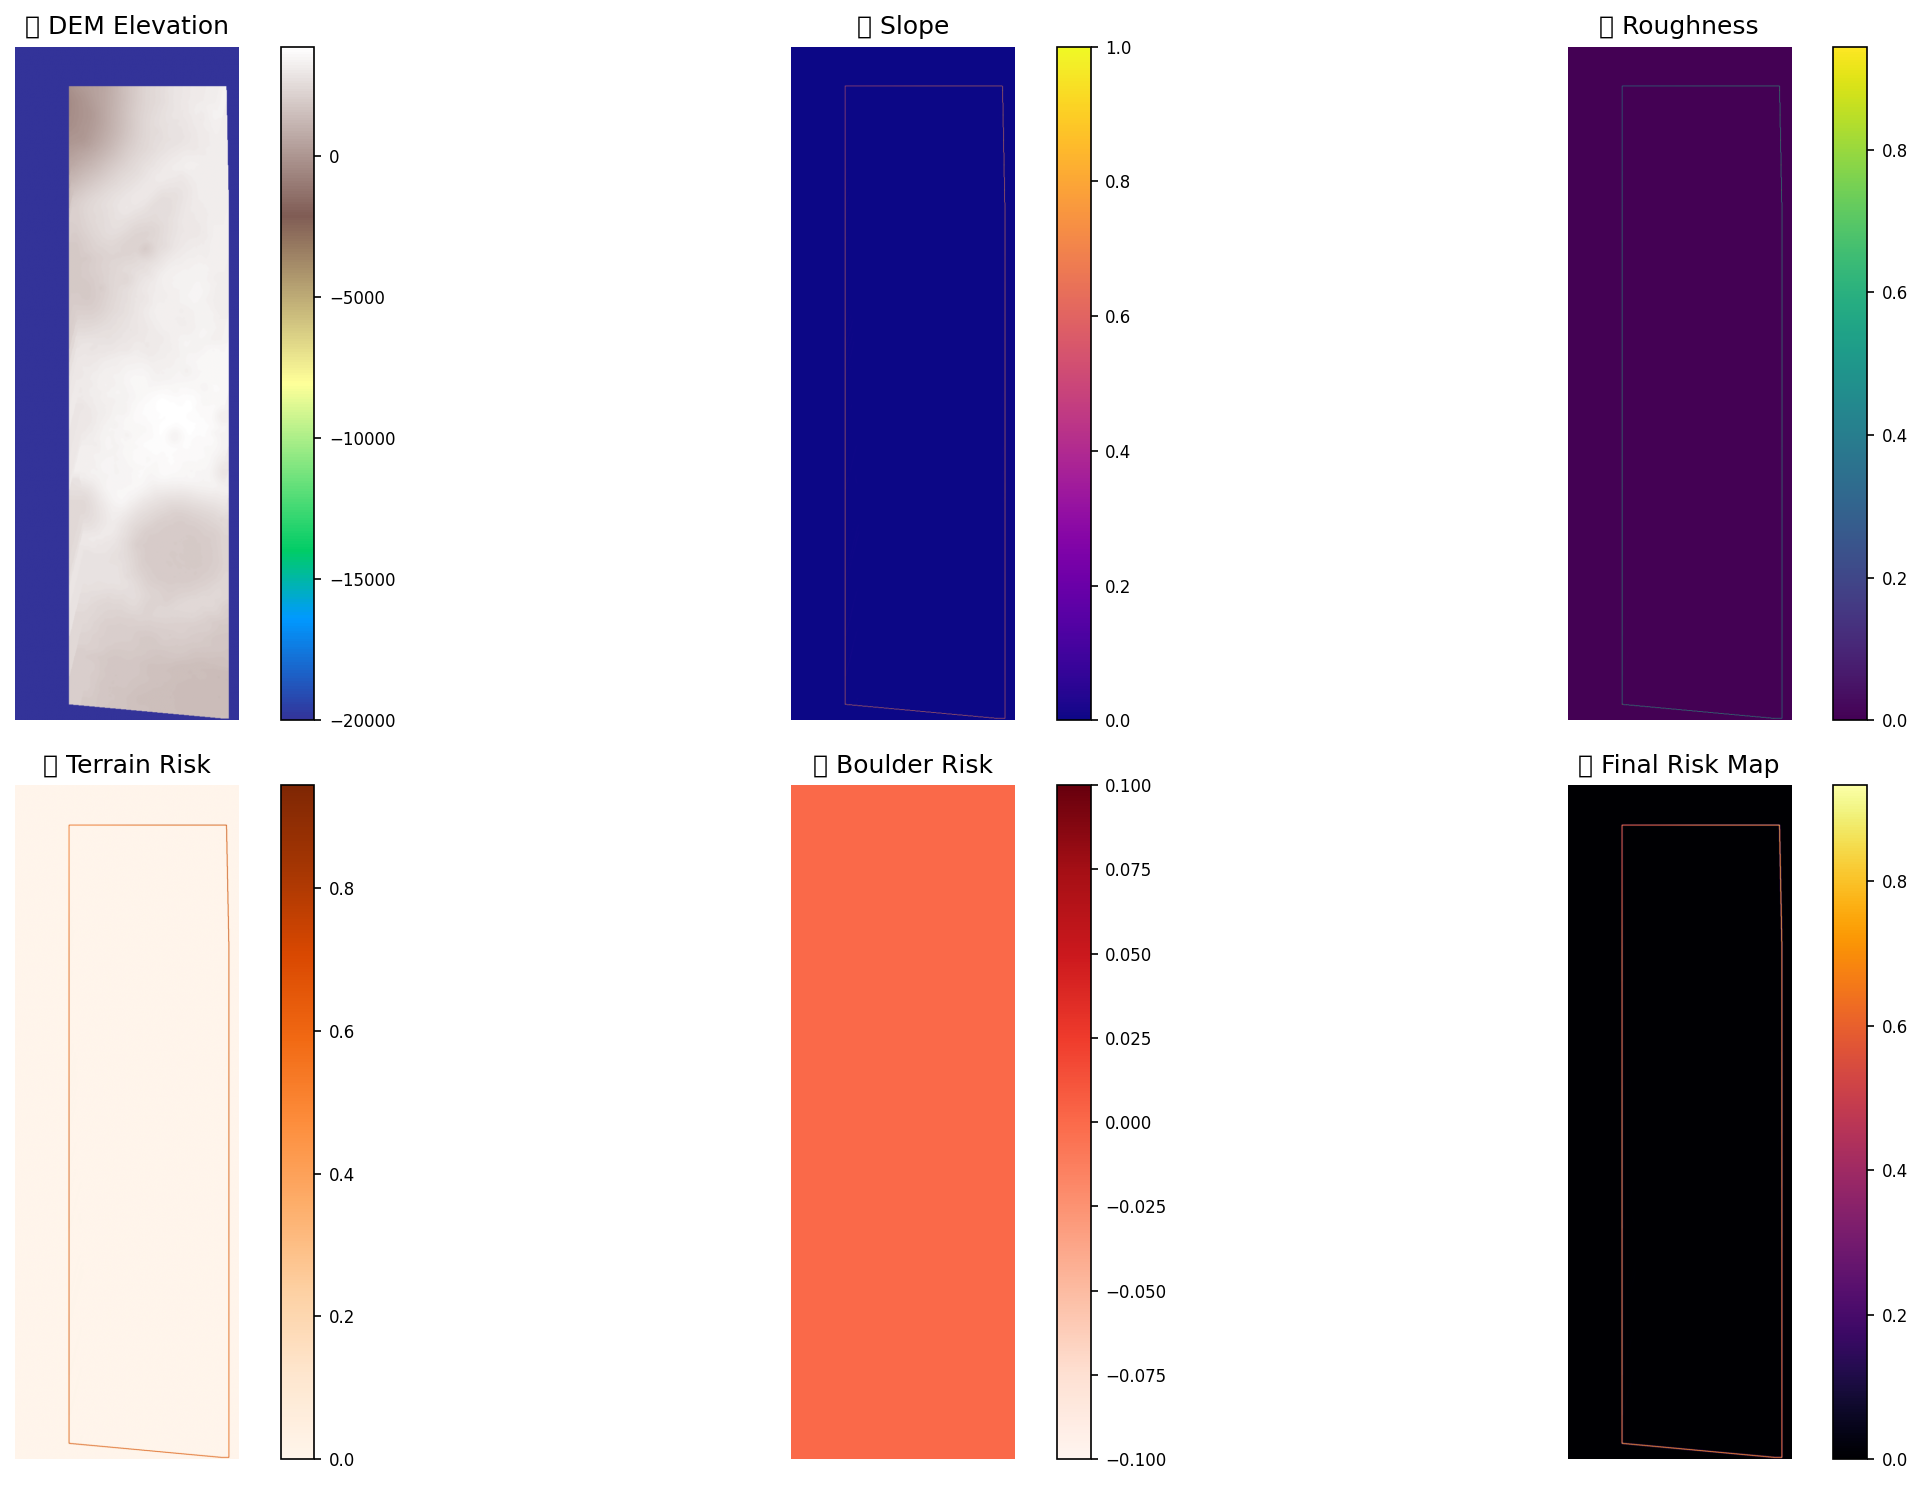

📦 Creating output package...

📈 ANALYSIS SUMMARY:
• Total pixels analyzed: 2,566,848
• Safe terrain coverage: 0.0%
• High risk areas (>0.7): 0.5%
• Average terrain risk: 0.006
• Average boulder risk: 0.000
• Peak risk value: 1.000
📥 Downloading results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
from scipy.ndimage.filters import generic_filter
from google.colab import files
import rasterio
from pathlib import Path
import zipfile
from numba import jit, prange
import warnings
warnings.filterwarnings('ignore')

@jit(nopython=True, parallel=True)
def fast_roughness_calculation(dem, window_size=3):
    """Optimized roughness calculation using Numba JIT compilation"""
    rows, cols = dem.shape
    roughness = np.zeros_like(dem)
    pad = window_size // 2

    for i in prange(pad, rows - pad):
        for j in prange(pad, cols - pad):
            # Extract window
            window_vals = dem[i-pad:i+pad+1, j-pad:j+pad+1].flatten()
            # Calculate standard deviation
            mean_val = np.mean(window_vals)
            variance = np.mean((window_vals - mean_val) ** 2)
            roughness[i, j] = np.sqrt(variance)

    return roughness

@jit(nopython=True, parallel=True)
def fast_boulder_risk(dem_shape, boulder_positions, influence_radius=200):
    """Vectorized boulder risk calculation"""
    rows, cols = dem_shape
    boulder_risk = np.zeros((rows, cols), dtype=np.float32)

    # Create coordinate grids
    y_coords = np.arange(rows, dtype=np.float32)
    x_coords = np.arange(cols, dtype=np.float32)

    for boulder_x, boulder_y in boulder_positions:
        for i in prange(rows):
            for j in prange(cols):
                dist_sq = (i - boulder_x)**2 + (j - boulder_y)**2
                boulder_risk[i, j] += np.exp(-dist_sq / influence_radius)

    return boulder_risk

def normalize_array(arr):
    """Fast normalization with handling of edge cases"""
    arr_min, arr_max = np.nanmin(arr), np.nanmax(arr)
    if arr_max == arr_min:
        return np.zeros_like(arr)
    return (arr - arr_min) / (arr_max - arr_min)

def efficient_slope_calculation(dem):
    """Optimized slope calculation using scipy's gradient"""
    # Use scipy's more efficient gradient calculation
    gy, gx = np.gradient(dem.astype(np.float32))
    slope = np.sqrt(gx**2 + gy**2)
    return normalize_array(slope)

def create_risk_visualization(layers, figsize=(20, 12), dpi=150):
    """Optimized visualization with better memory management"""
    fig, axs = plt.subplots(2, 3, figsize=figsize, dpi=dpi)

    # Pre-allocate for better memory usage
    for ax, (data, title, cmap) in zip(axs.flat, layers):
        # Use lower resolution for display, save high-res separately
        display_data = data[::2, ::2] if data.size > 1000000 else data
        im = ax.imshow(display_data, cmap=cmap, interpolation='bilinear')
        ax.set_title(title, fontsize=12)
        ax.axis('off')

        # Smaller colorbar for better performance
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    return fig

# 📤 Upload DEM (.tif) file
print("📁 Upload cropped DEM (TMC-derived .tif):")
uploaded = files.upload()
dem_path = list(uploaded.keys())[0]

# 📥 Load DEM with optimized settings
print("🔄 Loading and preprocessing DEM...")
with rasterio.open(dem_path) as src:
    # Read with optimal data type
    dem = src.read(1, masked=True).astype(np.float32)
    profile = src.profile
    transform = src.transform
    nodata = src.nodata

# 📐 Optimized preprocessing
if hasattr(dem, 'mask'):
    dem = dem.filled(np.nanmean(dem.compressed()))
else:
    dem[dem == nodata] = np.nan
    dem = np.nan_to_num(dem, nan=np.nanmean(dem[~np.isnan(dem)]))

print(f"📊 DEM shape: {dem.shape}, Data type: {dem.dtype}")

# ⛰️ Step 1: Optimized Slope Calculation
print("🔄 Calculating slope...")
slope = efficient_slope_calculation(dem)

# ⛰️ Step 2: Optimized Roughness Calculation
print("🔄 Calculating roughness...")
# Use scipy's generic_filter for better performance on large arrays
if dem.size > 500000:  # For large DEMs, use uniform filter approximation
    roughness = uniform_filter(dem, size=3, mode='reflect')
    roughness = normalize_array(np.abs(dem - roughness))
else:
    roughness = fast_roughness_calculation(dem, window_size=3)
    roughness = normalize_array(roughness)

# 🔥 Optimized Terrain Risk
print("🔄 Computing terrain risk...")
terrain_risk = (slope + roughness) * 0.5
terrain_risk = gaussian_filter(terrain_risk, sigma=1.0)
terrain_risk = normalize_array(terrain_risk)

# 🪨 Step 3: Optimized Boulder Risk
print("🔄 Simulating boulder risk...")
synthetic_boulders = np.array([(50, 60), (30, 90), (80, 40)], dtype=np.float32)

# Scale boulder positions to DEM size if needed
max_dim = max(dem.shape)
if max_dim > 100:
    scale_factor = max_dim / 100
    synthetic_boulders = synthetic_boulders * scale_factor

boulder_risk = fast_boulder_risk(dem.shape, synthetic_boulders, influence_radius=200)
boulder_risk = gaussian_filter(boulder_risk, sigma=2.0)
boulder_risk = normalize_array(boulder_risk)

# 🧠 Final Combined Risk Map
print("🔄 Creating final risk map...")
final_risk = 0.6 * terrain_risk + 0.4 * boulder_risk
final_risk = gaussian_filter(final_risk, sigma=1.0)
final_risk = normalize_array(final_risk)

# 🛡️ Safe zones with adaptive threshold
safe_threshold = np.percentile(final_risk, 30)  # Adaptive threshold
safe_mask = final_risk < safe_threshold

print(f"✅ Analysis complete! Safe zones: {np.sum(safe_mask)/safe_mask.size*100:.1f}% of terrain")

# 📊 Optimized Visualization
print("🔄 Creating visualizations...")
layers = [
    (dem, "🌑 DEM Elevation", 'terrain'),
    (slope, "📐 Slope", 'plasma'),
    (roughness, "⛰️ Roughness", 'viridis'),
    (terrain_risk, "🔥 Terrain Risk", 'Oranges'),
    (boulder_risk, "🪨 Boulder Risk", 'Reds'),
    (final_risk, "🛑 Final Risk Map", 'inferno')
]

# Create dashboard with optimized settings
fig = create_risk_visualization(layers, figsize=(18, 10), dpi=150)

# Save with optimized settings
print("💾 Saving results...")
plt.savefig("final_risk_dashboard.png", dpi=200, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# ✅ Save individual maps with optimized settings
Path("outputs").mkdir(exist_ok=True)

# Use optimized saving parameters
save_kwargs = {'dpi': 200, 'bbox_inches': 'tight', 'pad_inches': 0.1}

plt.figure(figsize=(10, 8))
plt.imshow(final_risk, cmap='inferno')
plt.colorbar(label='Risk Level', shrink=0.8)
plt.title('🛑 Combined Risk Map')
plt.axis('off')
plt.savefig("outputs/risk_map_combined.png", **save_kwargs)
plt.close()

plt.figure(figsize=(10, 8))
plt.imshow(terrain_risk, cmap='Oranges')
plt.colorbar(label='Terrain Risk', shrink=0.8)
plt.title('🔥 Terrain Risk')
plt.axis('off')
plt.savefig("outputs/terrain_risk.png", **save_kwargs)
plt.close()

plt.figure(figsize=(10, 8))
plt.imshow(boulder_risk, cmap='Reds')
plt.colorbar(label='Boulder Risk', shrink=0.8)
plt.title('🪨 Boulder Risk')
plt.axis('off')
plt.savefig("outputs/boulder_risk.png", **save_kwargs)
plt.close()

plt.figure(figsize=(10, 8))
plt.imshow(safe_mask.astype(float), cmap='RdYlGn')
plt.colorbar(label='Safe Zone (1=Safe, 0=Risk)', shrink=0.8)
plt.title('✅ Safe Zone Analysis')
plt.axis('off')
plt.savefig("outputs/safe_zone_mask.png", **save_kwargs)
plt.close()

# 🗜️ Efficient zip creation
print("📦 Creating output package...")
with zipfile.ZipFile("lunar_risk_outputs.zip", "w", zipfile.ZIP_DEFLATED, compresslevel=6) as zf:
    zf.write("final_risk_dashboard.png")
    for fname in Path("outputs").glob("*.png"):
        zf.write(fname, arcname=fname.name)

# 📊 Generate summary statistics
print("\n📈 ANALYSIS SUMMARY:")
print(f"• Total pixels analyzed: {dem.size:,}")
print(f"• Safe terrain coverage: {np.sum(safe_mask)/safe_mask.size*100:.1f}%")
print(f"• High risk areas (>0.7): {np.sum(final_risk > 0.7)/final_risk.size*100:.1f}%")
print(f"• Average terrain risk: {np.mean(terrain_risk):.3f}")
print(f"• Average boulder risk: {np.mean(boulder_risk):.3f}")
print(f"• Peak risk value: {np.max(final_risk):.3f}")

# 📥 Download zip
print("📥 Downloading results...")
files.download("lunar_risk_outputs.zip")

🚀 Rover Navigation System
📁 Found existing DEM files:
  1. ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem.tif
  2. ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem (8).tif
  3. ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem (4).tif
  4. ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem (2).tif
  5. ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem (6).tif
  6. ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem (5).tif
  7. ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem (3).tif
  8. ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem (7).tif
  9. ch1_tmc_20090429_I02090_D02099_231259_seg1_NA_dem (1).tif

Choose file (1-9) or 'u' to upload new: 1
📏 DEM loaded: 2784x922 pixels
🗻 Elevation range: -20000.0 to 3862.0
🎯 DEM size: 2784 x 922
Enter coordinates (row, col) or press Enter for defaults:
Start position (default: 696, 230): 
Goal position (default: 2088, 691): 
📍 Start: (696, 230), Goal: (2088, 691)

Risk map options:
1. Slope-based (realistic)
2. Random (for testing)
3. None


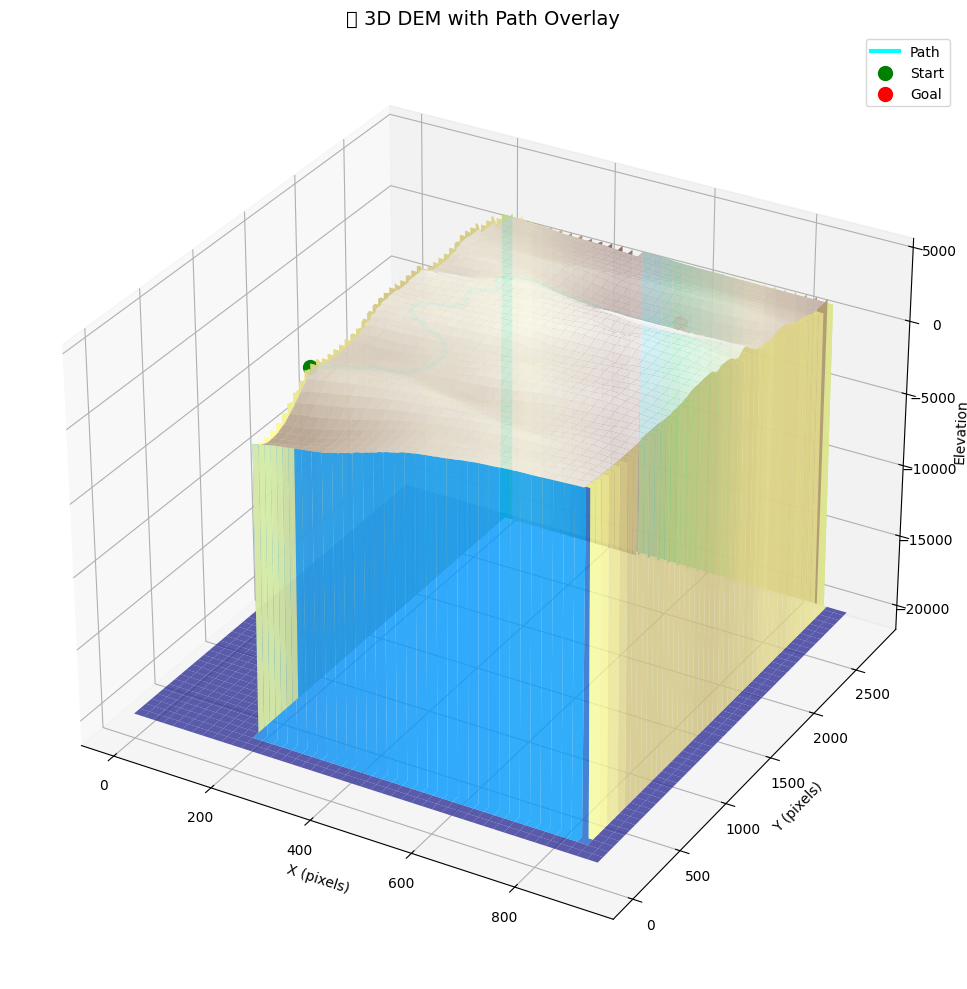

✅ Saved elevation profile to outputs/elevation_profile.png


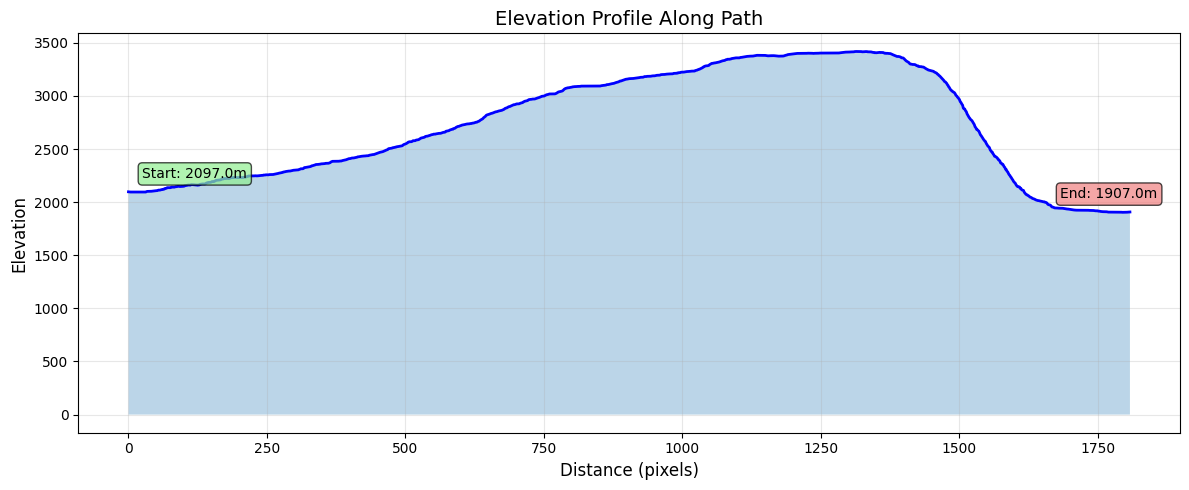

✅ Saved risk heatmap to outputs/risk_heatmap.png


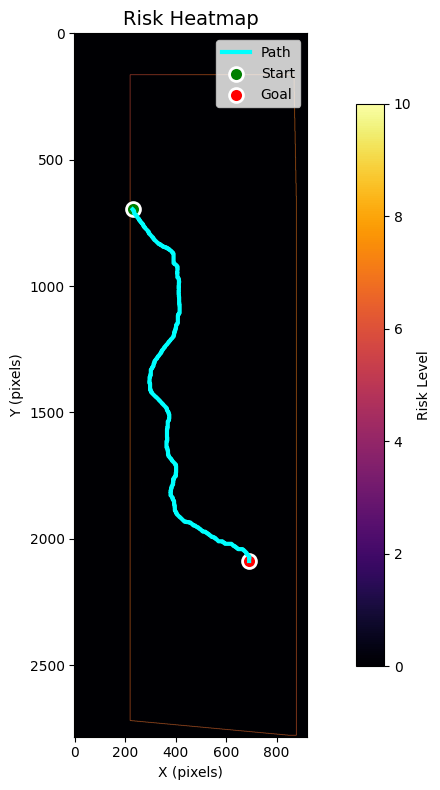


📋 Generating PDF report...
✅ PDF report saved: outputs/rover_navigation_report.pdf

⬇️  Downloading results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Analysis complete!
Path found with 1546 steps
Total distance: 1808.4 pixels
Elevation change: -190.0


In [ ]:

!pip install fpdf rasterio

# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from fpdf import FPDF
import os
import datetime
from google.colab import files
import rasterio
import heapq
from functools import lru_cache
from typing import Optional, List, Tuple, Union

# === Constants ===
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Load DEM ===
def load_dem_from_tif(filepath: str) -> np.ndarray:
    """Load DEM from TIFF file with proper handling of nodata values."""
    try:
        with rasterio.open(filepath) as src:
            dem = src.read(1).astype(float)
            print(f"📏 DEM loaded: {dem.shape[0]}x{dem.shape[1]} pixels")
            print(f"🗻 Elevation range: {np.nanmin(dem):.1f} to {np.nanmax(dem):.1f}")

            # Handle nodata values
            if src.nodata is not None:
                dem[dem == src.nodata] = np.nan
                nodata_count = np.isnan(dem).sum()
                if nodata_count > 0:
                    print(f"⚠️  Filled {nodata_count} nodata pixels with mean elevation")

            return np.nan_to_num(dem, nan=np.nanmean(dem))
    except Exception as e:
        print(f"❌ Error loading DEM: {e}")
        raise

def check_existing_files():
    """Check for existing DEM files in the current directory."""
    tif_files = [f for f in os.listdir('.') if f.lower().endswith(('.tif', '.tiff'))]
    return tif_files

def get_dem_file():
    """Get DEM file either from existing files or upload new one."""
    existing_files = check_existing_files()

    if existing_files:
        print("📁 Found existing DEM files:")
        for i, file in enumerate(existing_files, 1):
            print(f"  {i}. {file}")

        choice = input(f"\nChoose file (1-{len(existing_files)}) or 'u' to upload new: ").strip().lower()

        if choice == 'u':
            print("📤 Upload your DEM (.tif) file:")
            uploaded = files.upload()
            if uploaded:
                return list(uploaded.keys())[0]
            else:
                print("❌ No file uploaded")
                return None
        else:
            try:
                file_index = int(choice) - 1
                if 0 <= file_index < len(existing_files):
                    return existing_files[file_index]
                else:
                    print("❌ Invalid choice")
                    return None
            except ValueError:
                print("❌ Invalid input")
                return None
    else:
        print("📤 No existing DEM files found. Upload your DEM (.tif) file:")
        uploaded = files.upload()
        if uploaded:
            return list(uploaded.keys())[0]
        else:
            print("❌ No file uploaded")
            return None

# === A* Pathfinding ===
@lru_cache(maxsize=10000)
def heuristic(a: Tuple[int, int], b: Tuple[int, int]) -> float:
    """Cached Euclidean distance heuristic."""
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def astar(dem: np.ndarray, start: Tuple[int, int], goal: Tuple[int, int],
          risk_map: Optional[np.ndarray] = None, elevation_weight: float = 1.0) -> Optional[List[Tuple[int, int]]]:
    """
    A* pathfinding with optional elevation weighting.

    Args:
        dem: Digital elevation model
        start: Starting position (row, col)
        goal: Goal position (row, col)
        risk_map: Optional risk map
        elevation_weight: Weight for elevation differences (default: 1.0)
    """
    rows, cols = dem.shape

    # Validate coordinates
    if not (0 <= start[0] < rows and 0 <= start[1] < cols):
        print(f"❌ Invalid start position: {start}")
        return None
    if not (0 <= goal[0] < rows and 0 <= goal[1] < cols):
        print(f"❌ Invalid goal position: {goal}")
        return None

    print(f"🎯 Finding path from {start} to {goal}")

    open_set = [(heuristic(start, goal), 0, start)]
    visited = set()
    g_score = {start: 0}
    came_from = {}
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    diagonal_cost = np.sqrt(2)

    while open_set:
        f_score, current_g, current = heapq.heappop(open_set)
        if current in visited: continue
        visited.add(current)

        if current == goal:
            print("✅ A* path found!")
            return _reconstruct_path(came_from, current)

        for dr, dc in neighbors:
            nr, nc = current[0] + dr, current[1] + dc
            if not (0 <= nr < rows and 0 <= nc < cols): continue
            neighbor = (nr, nc)
            if neighbor in visited: continue

            # Calculate movement cost
            elev_diff = abs(dem[nr, nc] - dem[current[0], current[1]]) * elevation_weight
            move_cost = (diagonal_cost if abs(dr)+abs(dc)==2 else 1.0) + elev_diff

            # Add risk if available
            if risk_map is not None:
                move_cost += risk_map[nr, nc]

            tentative_g = current_g + move_cost
            if neighbor in g_score and tentative_g >= g_score[neighbor]: continue

            came_from[neighbor] = current
            g_score[neighbor] = tentative_g
            f_score = tentative_g + heuristic(neighbor, goal)
            heapq.heappush(open_set, (f_score, tentative_g, neighbor))

    print("❌ No path found.")
    return None

def _reconstruct_path(came_from: dict, current: Tuple[int, int]) -> List[Tuple[int, int]]:
    """Reconstruct path from came_from dictionary."""
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    return path[::-1]

# === Visualizations ===
def plot_3d_path_over_terrain(dem, path, save_path='outputs/3d_path.png'):
    """Plot 3D terrain with path overlay."""
    print("🌄 Plotting 3D terrain with path...")
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Downsample large DEMs for performance
    downsample = max(1, min(dem.shape) // 200)
    X, Y = np.meshgrid(np.arange(0, dem.shape[1], downsample),
                       np.arange(0, dem.shape[0], downsample))
    dem_ds = dem[::downsample, ::downsample]

    ax.plot_surface(X, Y, dem_ds, cmap='terrain', alpha=0.8, linewidth=0)

    if path:
        path = np.array(path)
        Z_path = dem[path[:, 0], path[:, 1]]
        ax.plot(path[:, 1], path[:, 0], Z_path, color='cyan', linewidth=3, label='Path')
        ax.scatter(path[0,1], path[0,0], Z_path[0], color='green', s=100, label='Start')
        ax.scatter(path[-1,1], path[-1,0], Z_path[-1], color='red', s=100, label='Goal')
        ax.legend()

    ax.set_title("🗺️ 3D DEM with Path Overlay", fontsize=14)
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")
    ax.set_zlabel("Elevation")
    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    print(f"✅ Saved 3D visualization to {save_path}")
    plt.show()

def plot_elevation_profile(dem, path, save_path='outputs/elevation_profile.png'):
    """Plot elevation profile along the path."""
    if path is None:
        print("⚠️  No path to plot elevation profile")
        return

    path = np.array(path)
    elevations = dem[path[:, 0], path[:, 1]]
    distances = np.cumsum([0] + [np.linalg.norm(path[i] - path[i-1]) for i in range(1, len(path))])

    plt.figure(figsize=(12, 5))
    plt.plot(distances, elevations, color='blue', linewidth=2)
    plt.fill_between(distances, elevations, alpha=0.3)

    # Add annotations
    plt.annotate(f'Start: {elevations[0]:.1f}m', xy=(distances[0], elevations[0]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', fc='lightgreen', alpha=0.7))
    plt.annotate(f'End: {elevations[-1]:.1f}m', xy=(distances[-1], elevations[-1]),
                xytext=(-50, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', fc='lightcoral', alpha=0.7))

    plt.xlabel('Distance (pixels)', fontsize=12)
    plt.ylabel('Elevation', fontsize=12)
    plt.title('Elevation Profile Along Path', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    print(f"✅ Saved elevation profile to {save_path}")
    plt.show()

def plot_risk_heatmap(risk_map, path=None, save_path='outputs/risk_heatmap.png'):
    """Plot risk heatmap with optional path overlay."""
    plt.figure(figsize=(10, 8))
    im = plt.imshow(risk_map, cmap='inferno', origin='upper')

    if path:
        path = np.array(path)
        plt.plot(path[:,1], path[:,0], 'cyan', linewidth=3, label='Path')
        plt.scatter(path[0,1], path[0,0], color='green', s=100, label='Start',
                   edgecolors='white', linewidth=2)
        plt.scatter(path[-1,1], path[-1,0], color='red', s=100, label='Goal',
                   edgecolors='white', linewidth=2)
        plt.legend()

    plt.colorbar(im, label='Risk Level', shrink=0.8)
    plt.title('Risk Heatmap', fontsize=14)
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    print(f"✅ Saved risk heatmap to {save_path}")
    plt.show()

# === PDF Report ===
def generate_pdf_report(path, dem, risk_map, filename="outputs/rover_navigation_report.pdf"):
    """Generate comprehensive PDF report."""
    # Use default encoding for FPDF, and explicitly encode problematic strings
    pdf = FPDF(unit='mm', format='A4')
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()

    # Title
    pdf.set_font("Arial", 'B', 18)
    pdf.cell(0, 15, "Rover Navigation Analysis Report", ln=True, align='C')

    # Header info
    pdf.set_font("Arial", '', 11)
    pdf.ln(5)
    pdf.cell(0, 8, f"Generated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", ln=True)
    pdf.cell(0, 8, f"DEM Dimensions: {dem.shape[0]} x {dem.shape[1]} pixels", ln=True)
    pdf.cell(0, 8, f"Elevation Range: {np.min(dem):.1f} to {np.max(dem):.1f}", ln=True)

    if path:
        pdf.ln(5)
        pdf.set_font("Arial", 'B', 14)
        pdf.cell(0, 10, "Path Analysis Summary", ln=True)
        pdf.set_font("Arial", '', 10)

        # Calculate metrics
        path_np = np.array(path)
        elevations = dem[path_np[:, 0], path_np[:, 1]]
        distances = np.cumsum([0] + [np.linalg.norm(path_np[i] - path_np[i-1]) for i in range(1, len(path_np))])
        total_dist = distances[-1]
        elevation_gain = np.sum(np.clip(np.diff(elevations), 0, None))
        elevation_loss = abs(np.sum(np.clip(np.diff(elevations), None, 0)))

        # Path statistics - encode bullet points
        pdf.cell(0, 6, f"• Path Length: {len(path)} steps".encode('utf-8').decode('latin-1'), ln=True)
        pdf.cell(0, 6, f"• Total Distance: {total_dist:.1f} pixels".encode('utf-8').decode('latin-1'), ln=True)
        pdf.cell(0, 6, f"• Start Elevation: {elevations[0]:.1f}".encode('utf-8').decode('latin-1'), ln=True)
        pdf.cell(0, 6, f"• End Elevation: {elevations[-1]:.1f}".encode('utf-8').decode('latin-1'), ln=True)
        pdf.cell(0, 6, f"• Elevation Gain: {elevation_gain:.1f}".encode('utf-8').decode('latin-1'), ln=True)
        pdf.cell(0, 6, f"• Elevation Loss: {elevation_loss:.1f}".encode('utf-8').decode('latin-1'), ln=True)

        if risk_map is not None:
            risks = risk_map[path_np[:, 0], path_np[:, 1]]
            pdf.cell(0, 6, f"• Total Risk Score: {np.sum(risks):.1f}".encode('utf-8').decode('latin-1'), ln=True)
            pdf.cell(0, 6, f"• Average Risk: {np.mean(risks):.2f}".encode('utf-8').decode('latin-1'), ln=True)

    # Add images
    for img in ["risk_heatmap.png", "3d_path.png", "elevation_profile.png"]:
        img_path = os.path.join(OUTPUT_DIR, img)
        if os.path.exists(img_path):
            pdf.add_page()
            pdf.set_font("Arial", 'B', 12)
            # Encode image titles
            pdf.cell(0, 10, img.replace('.png', '').replace('_', ' ').title().encode('utf-8').decode('latin-1'), ln=True)
            pdf.ln(3)
            try:
                pdf.image(img_path, w=180)
            except Exception as e:
                print(f"⚠️  Could not add image {img}: {e}")

    pdf.output(filename)
    print(f"✅ PDF report saved: {filename}")
    return filename

# === Interactive Demo Functions ===
def get_user_coordinates(dem_shape):
    """Get start/goal coordinates from user or use intelligent defaults."""
    rows, cols = dem_shape

    print(f"🎯 DEM size: {rows} x {cols}")
    print("Enter coordinates (row, col) or press Enter for defaults:")

    try:
        start_input = input(f"Start position (default: {rows//4}, {cols//4}): ").strip()
        if start_input:
            start = tuple(map(int, start_input.split(',')))
        else:
            start = (rows//4, cols//4)

        goal_input = input(f"Goal position (default: {3*rows//4}, {3*cols//4}): ").strip()
        if goal_input:
            goal = tuple(map(int, goal_input.split(',')))
        else:
            goal = (3*rows//4, 3*cols//4)

        return start, goal
    except:
        print("⚠️  Using default coordinates")
        return (rows//4, cols//4), (3*rows//4, 3*cols//4)

def create_risk_map(dem, risk_type='slope'):
    """Create risk map based on terrain features."""
    if risk_type == 'slope':
        # Calculate slope-based risk
        gy, gx = np.gradient(dem)
        slope = np.sqrt(gx**2 + gy**2)
        # Normalize slope to a 0-10 risk scale
        max_slope = np.max(slope) if np.max(slope) > 0 else 1.0 # Avoid division by zero
        risk_map = np.clip(slope / max_slope * 10, 0, 10)
        print("🔺 Generated slope-based risk map")
    elif risk_type == 'random':
        # Random risk for testing
        risk_map = np.random.rand(*dem.shape) * 5
        print("🎲 Generated random risk map")
    else:
        # No risk
        risk_map = np.zeros(dem.shape)
        print("✅ No risk map applied")

    return risk_map

# === Main Demo ===
def main():
    """Main execution function."""
    print("🚀 Rover Navigation System")
    print("=" * 50)

    # Get DEM file (check existing or upload new)
    dem_path = get_dem_file()
    if not dem_path:
        print("❌ No DEM file available")
        return

    # Load DEM
    dem = load_dem_from_tif(dem_path)

    # Get coordinates
    start, goal = get_user_coordinates(dem.shape)
    print(f"📍 Start: {start}, Goal: {goal}")

    # Create risk map
    print("\nRisk map options:")
    print("1. Slope-based (realistic)")
    print("2. Random (for testing)")
    print("3. None")

    risk_choice = input("Select risk type (1-3, default: 1): ").strip()
    risk_types = {'1': 'slope', '2': 'random', '3': 'none'}
    risk_type = risk_types.get(risk_choice, 'slope')

    risk_map = create_risk_map(dem, risk_type) if risk_type != 'none' else None

    # Run pathfinding
    print("\n🔍 Running A* pathfinding...")
    # Pass elevation_weight to astar if needed, e.g., elevation_weight=2.0
    path = astar(dem, start, goal, risk_map)

    if path is None:
        print("❌ No path found! Try different start/goal positions.")
        return

    # Generate visualizations
    print("\n📊 Generating visualizations...")
    plot_3d_path_over_terrain(dem, path)
    plot_elevation_profile(dem, path)

    if risk_map is not None:
        plot_risk_heatmap(risk_map, path)

    # Generate report
    print("\n📋 Generating PDF report...")
    pdf_path = generate_pdf_report(path, dem, risk_map)

    # Download results
    print("\n⬇️  Downloading results...")
    files.download(pdf_path)

    print("\n✅ Analysis complete!")
    print(f"Path found with {len(path)} steps")
    if path:
        path_np = np.array(path)
        elevations = dem[path_np[:, 0], path_np[:, 1]]
        distances = np.cumsum([0] + [np.linalg.norm(path_np[i] - path_np[i-1]) for i in range(1, len(path_np))])
        print(f"Total distance: {distances[-1]:.1f} pixels")
        print(f"Elevation change: {elevations[-1] - elevations[0]:.1f}")

# === Run the demo ===
if __name__ == "__main__":
    main()